In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from scipy import stats
from pathlib import Path, PureWindowsPath


In [2]:
def extract_dataset_info(data_path):
    # extract information from train.txt
    f = open(os.path.join(data_path, "train.txt"), "r")
    contents_train = f.readlines()
    label_classes, label_train_list, img_train_list = [], [], []
    for sample in contents_train:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        if label not in label_classes:
            label_classes.append(label)
        label_train_list.append(sample[0])
        img_train_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))
    print('Classes: {}'.format(label_classes))

    # extract information from test.txt
    f = open(os.path.join(data_path, "test.txt"), "r")
    contents_test = f.readlines()
    label_test_list, img_test_list = [], []
    for sample in contents_test:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        label_test_list.append(label)
        img_test_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))  # you can directly use img_path if you run in Windows

    return label_classes, label_train_list, img_train_list, label_test_list, img_test_list


In [3]:
def compute_dsift(img, stride, size):
    # To do
    sift = cv2.xfeatures2d.SIFT_create()

    step_size = 20
    
    ## 不确定 KeyPoint(x, y, size)
    kp = [cv2.KeyPoint(x+size/2, y+size/2, size) for y in range(0, img.shape[0], stride) 
                                    for x in range(0, img.shape[1], stride)]

    kp1, dense_feature = sift.compute(img , kp)
    return dense_feature

In [93]:
def get_tiny_image(img, output_size):
    # To do
    img_resize = cv2.resize(img, output_size, interpolation = cv2.INTER_AREA)
    #normalization
    
    feature = np.zeros(output_size)
    
    feature_omean= img_resize- np.mean(img_resize)
       
    feature = feature_omean / np.linalg.norm(feature_omean.reshape
                                             ((1,np.prod(feature_omean.shape))))
    
    return feature

In [94]:
def predict_knn(feature_train, label_train, feature_test, k):
    # To do
    nbrs = NearestNeighbors(algorithm='auto').fit(feature_train)
    
    distances_map,indices_map =nbrs.kneighbors(feature_test,n_neighbors=k)
    
    label_test_pred = np.zeros(len(indices_map))
    
    for num in range(len(indices_map)):
        label_test_pred[num] = np.argmax(np.bincount(label_train[indices_map[num,:]]))
    
    return label_test_pred

In [95]:
def classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do
    #1
    feature_vec = []
    output_size = output_size= (16,16)
    k = 10
    for name in img_train_list :
        img = cv2.imread(name,0)
        feature = get_tiny_image(img, output_size)
        feature_vec.append( feature.reshape(np.prod(feature.shape)))
    #2
    feature_test_vec = []
    for name in img_test_list :
        img = cv2.imread(name,0)
        feature_test = get_tiny_image(img, output_size)
        feature_test_vec.append( feature_test.reshape(np.prod(feature_test.shape)))  
    #3  
    label_train_set = []
    for item in label_train_list:
        label_train_set.append(label_classes.index(item))
    
    label_train_set = np.array(label_train_set)
    #4
    label_test_set = []
    for item in label_test_list:
        label_test_set.append(label_classes.index(item))
    
    label_test_set = np.array(label_test_set)
    
    
    #predict
    label_test_pred = predict_knn(feature_vec, label_train_set, feature_test_vec, k)
    
    #confusion matrix]
    from sklearn.metrics import confusion_matrix
    
    y_true = label_test_set
    y_pred = label_test_pred
    confusion = confusion_matrix(y_true, y_pred)
    accuracy = np.trace(confusion)/np.sum(np.sum(confusion))
    
    
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

In [96]:
def build_visual_dictionary(dense_feature_list, dic_size=50):
    # To do
    dense_feature=np.zeros((1,128))
    
    for item in dense_feature_list:

        dense_feature = np.concatenate((dense_feature, item), axis=0)
    
    dense_feature_set = np.delete(dense_feature, 0, 0)
    
    kmeans = KMeans(n_clusters = dic_size,n_init=20,max_iter=800).fit(dense_feature_set)
    vocab = kmeans.cluster_centers_
    return vocab

In [97]:
def compute_bow(feature, vocab):
    # To do
    nbrs = NearestNeighbors(algorithm='auto').fit(vocab) 
    
    distances_map,indices_map =nbrs.kneighbors(feature,n_neighbors=1)
    
    bow_feature_pre = indices_map.reshape((1,len(indices_map)))
    
    #print(bow_feature_pre)
    
    bow_feature = np.bincount(bow_feature_pre[0],minlength=len(vocab))/len(feature)
    
    
    return bow_feature

In [98]:
#k = [1,3,4,2,4,4,4,5,2,4,3,3,2,3,5,6,4,3,3]


In [99]:
def classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do
    stride, size = (20,20)
    cluster_num = 60
    
    dense_feature_list=[]
    for name in img_train_list :
        img = cv2.imread(name,0)
        dense_feature = compute_dsift(img, stride, size)
        dense_feature_list.append(dense_feature)

    vocab = build_visual_dictionary(dense_feature_list, cluster_num)
    np.savetxt('test_knn_bow_out', vocab, delimiter=',')
    
    vocab_feature_list=np.zeros((1,cluster_num))
    for name in img_train_list :
        img = cv2.imread(name,0)
        dense_feature = compute_dsift(img, stride, size)
        
        bow_feature = compute_bow(dense_feature, vocab)
        
        #print(bow_feature.shape)
        
        vocab_feature_list = np.concatenate((vocab_feature_list, np.array([bow_feature])), axis=0)
        
    vocab_feature_list = np.delete(vocab_feature_list, 0, 0)
        
        #vocab_feature_list.append(bow_feature)
    
    #2
    vocab_feature_test_list = np.zeros((1,cluster_num))
    for name in img_test_list :
        img = cv2.imread(name,0)
        dense_feature_test = compute_dsift(img, stride, size)
        
        bow_feature_test = compute_bow(dense_feature_test, vocab)
        
        #vocab_feature_test_list.append(dense_feature_test)
        vocab_feature_test_list = np.concatenate((vocab_feature_test_list, np.array([bow_feature_test])), axis=0)
        
    vocab_feature_test_list = np.delete(vocab_feature_test_list, 0, 0)
        
    #3  
    label_train_set = []
    for item in label_train_list:
        label_train_set.append(label_classes.index(item))
    
    label_train_set = np.array(label_train_set)
    #4
    label_test_set = []
    for item in label_test_list:
        label_test_set.append(label_classes.index(item))
    
    label_test_set = np.array(label_test_set)
    
    k = 10
    #print(vocab_feature_list.shape,vocab_feature_test_list.shape)
    
    label_test_pred = predict_knn(vocab_feature_list, label_train_set, vocab_feature_test_list, k)
    
    
    from sklearn.metrics import confusion_matrix
    
    y_true = label_test_set
    y_pred = label_test_pred
    confusion = confusion_matrix(y_true, y_pred)
    accuracy = np.trace(confusion)/np.sum(np.sum(confusion))
    
    
    visualize_confusion_matrix(confusion, accuracy, label_classes)

    return confusion, accuracy

Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']
(1500, 60) (1500, 60)


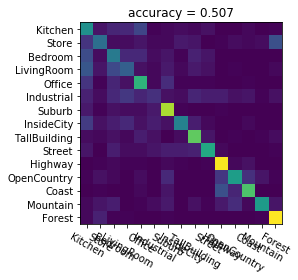

(array([[43,  5,  9, 10, 18,  1,  2,  3,  2,  4,  0,  0,  2,  0,  1],
        [13, 31,  3,  3,  5,  2,  2,  6,  5,  0,  1,  3,  2,  3, 21],
        [20,  3, 35, 10, 10,  3,  5,  1,  8,  5,  0,  0,  0,  0,  0],
        [23,  5, 19, 26,  4,  2,  6,  2,  6,  4,  0,  1,  0,  0,  2],
        [13,  1,  9,  4, 56,  2, 11,  1,  1,  1,  0,  0,  1,  0,  0],
        [ 8,  3, 10, 14,  9, 12,  4,  3,  9,  7,  7,  4,  5,  1,  4],
        [ 6,  1,  4,  3,  3,  6, 75,  1,  0,  0,  1,  0,  0,  0,  0],
        [15,  4,  7, 10,  4,  7,  4, 38,  7,  2,  0,  0,  2,  0,  0],
        [ 3,  2,  4,  2,  7,  4,  0,  3, 65,  5,  0,  1,  0,  1,  3],
        [ 5,  0,  7,  3,  3,  5,  7,  7,  8, 52,  2,  0,  0,  0,  1],
        [ 0,  1,  2,  1,  1,  0,  2,  1,  0,  1, 85,  2,  4,  0,  0],
        [ 1,  4,  2,  0,  3,  0, 10,  0,  0,  0, 14, 48, 12,  5,  1],
        [ 0,  1,  0,  0,  2,  0,  5,  0,  0,  0, 21,  9, 62,  0,  0],
        [ 2,  5,  7,  0,  1,  3,  6,  0,  4,  1,  6, 11,  2, 47,  5],
        [ 2,  8,  1,

In [100]:
label_classes, label_train_list, img_train_list, label_test_list, img_test_list = extract_dataset_info("./scene_classification_data")
    
classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

In [101]:
def predict_svm(feature_train, label_train, feature_test, n_classes):
    # To do
    clf = LinearSVC(tol=1e-5,C=1.0) 
    clf.fit(feature_train, label_train)  
    
    label_test_pred = clf.predict(feature_test)
    
    
    return label_test_pred

In [102]:
def classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    # To do
    
    stride, size = (20,20)
    cluster_num = 60
    
    dense_feature_list=[]
    for name in img_train_list :
        img = cv2.imread(name,0)
        dense_feature = compute_dsift(img, stride, size)
        dense_feature_list.append(dense_feature)

    vocab = build_visual_dictionary(dense_feature_list, cluster_num)
    np.savetxt('test_knn_bow_out', vocab, delimiter=',')
    
    vocab_feature_list=np.zeros((1,cluster_num))
    for name in img_train_list :
        img = cv2.imread(name,0)
        dense_feature = compute_dsift(img, stride, size)
        
        bow_feature = compute_bow(dense_feature, vocab)
        
        #print(bow_feature.shape)
        
        vocab_feature_list = np.concatenate((vocab_feature_list, np.array([bow_feature])), axis=0)
        
    vocab_feature_list = np.delete(vocab_feature_list, 0, 0)
        
        #vocab_feature_list.append(bow_feature)
    
    #2
    vocab_feature_test_list = np.zeros((1,cluster_num))
    for name in img_test_list :
        img = cv2.imread(name,0)
        dense_feature_test = compute_dsift(img, stride, size)
        
        bow_feature_test = compute_bow(dense_feature_test, vocab)
        
        #vocab_feature_test_list.append(dense_feature_test)
        vocab_feature_test_list = np.concatenate((vocab_feature_test_list, np.array([bow_feature_test])), axis=0)
        
    vocab_feature_test_list = np.delete(vocab_feature_test_list, 0, 0)
        
    #3  
    label_train_set = []
    for item in label_train_list:
        label_train_set.append(label_classes.index(item))
    
    label_train_set = np.array(label_train_set)
    #4
    label_test_set = []
    for item in label_test_list:
        label_test_set.append(label_classes.index(item))
    
    label_test_set = np.array(label_test_set)
    
    k = 10
    #print(vocab_feature_list.shape,vocab_feature_test_list.shape)
    
    label_test_pred = predict_svm(vocab_feature_list, label_train_set, vocab_feature_test_list,0)
    
    from sklearn.metrics import confusion_matrix
    
    y_true = label_test_set
    y_pred = label_test_pred
    confusion = confusion_matrix(y_true, y_pred)
    accuracy = np.trace(confusion)/np.sum(np.sum(confusion))
    
    visualize_confusion_matrix(confusion, accuracy, label_classes)
    return confusion, accuracy

In [103]:
def visualize_confusion_matrix(confusion, accuracy, label_classes):
    plt.title("accuracy = {:.3f}".format(accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    plt.show()


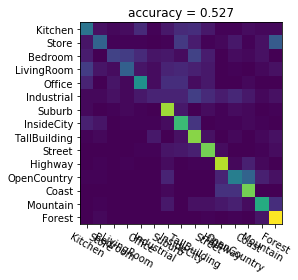

(array([[35,  4,  2,  3, 11,  1,  6, 11, 12,  6,  1,  1,  3,  2,  2],
        [ 5, 29,  1,  1,  1,  0,  1, 15,  7,  1,  2,  6,  1,  4, 26],
        [ 7,  0, 18, 16, 11,  5,  6,  3, 18,  7,  0,  3,  2,  4,  0],
        [16,  5,  3, 28,  5,  3,  9, 10,  8,  6,  0,  1,  0,  2,  4],
        [ 9,  0,  5,  2, 46,  3, 12, 12,  3,  6,  0,  0,  2,  0,  0],
        [ 2,  2,  4,  2,  6,  9,  9,  9, 17, 11,  7, 10,  6,  2,  4],
        [ 2,  0,  1,  2,  1,  0, 78,  6,  0,  3,  1,  3,  2,  0,  1],
        [ 8,  5,  0,  1,  1,  1,  3, 62, 14,  0,  1,  1,  2,  1,  0],
        [ 1,  2,  0,  0,  0,  6,  0,  4, 75,  4,  0,  2,  0,  2,  4],
        [ 0,  0,  0,  0,  1,  1,  5,  6,  8, 72,  3,  0,  0,  1,  3],
        [ 0,  1,  0,  1,  0,  0,  3,  0,  1,  1, 81,  2,  8,  2,  0],
        [ 1,  1,  0,  0,  0,  0,  9,  0,  0,  0,  9, 39, 29,  8,  4],
        [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0, 13, 13, 72,  0,  0],
        [ 0,  1,  0,  0,  0,  0,  6,  0,  4,  4,  6,  8,  3, 56, 12],
        [ 0,  2,  0,

In [104]:
classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)
    

Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']


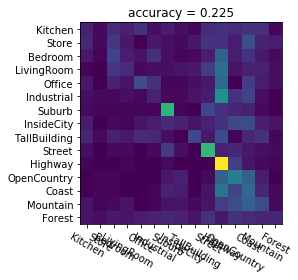

KeyboardInterrupt: 

In [34]:
if __name__ == '__main__':
    # To do: replace with your dataset path
    label_classes, label_train_list, img_train_list, label_test_list, img_test_list = extract_dataset_info("./scene_classification_data")
    
    classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

    classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)
    
    classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)